In [5]:
%matplotlib inline


# AkidaNet/ImageNet inference

This tutorial presents how to convert, map, and capture performance from AKD1000 Hardware using an
AkidaNet model.

AkidaNet architecture is a [MobileNet v1-inspired](https://arxiv.org/abs/1704.04861)_ architecture
optimized for implementation on Akida 1.0: it exploits the richer expressive power of standard
convolutions in early layers, but uses separable convolutions in later layers where filter memory is
limiting.

As [ImageNet](https://www.image-net.org/)_ images are not publicly available, performance is
assessed using a set of 10 copyright free images that were found on Google using ImageNet class
names.

.. Note::
    This tutorial uses an Akida 1.0 architecture to show AKD1000 mapping and performance. See the
    [dedicated tutorial](../quantization/plot_1_upgrading_to_2.0.html)_ for 1.0 and 2.0
    differences.


## 1. Dataset preparation

Test images all have at least 256 pixels in the smallest dimension. They must
be preprocessed to fit in the model. The ``imagenet.preprocessing.get_preprocessed_samples``
function loads and preprocesses (decodes, crops and extracts a square
224x224x3 patch from an input image) a set of 10 ImageNet-like images.

.. Note:: Input size is here set to 224x224x3 as this is what is used by the
          model presented in the next section.



In [6]:
import akida
import numpy as np
from akida_models.imagenet import get_preprocessed_samples

# Model specification and hyperparameters
NUM_CHANNELS = 3
IMAGE_SIZE = 224

# Load the preprocessed images and their corresponding labels for the test set
x_test, labels_test = get_preprocessed_samples(IMAGE_SIZE, NUM_CHANNELS)
print(f'{x_test.shape[0]} images and their labels are loaded and preprocessed.')

10 images and their labels are loaded and preprocessed.


## 2. Pretrained quantized model

The Akida model zoo contains a [pretrained quantized helper](../../api_reference/akida_models_apis.html#akida_models.akidanet_imagenet_pretrained).

The quantization scheme for this model is the following:

 * the first layer has 8-bit weights,
 * all other layers have 4-bit weights,
 * all activations are 4-bit.



In [7]:
from cnn2snn import set_akida_version, AkidaVersion
from akida_models import akidanet_imagenet_pretrained

# Use a quantized model with pretrained quantized weights
with set_akida_version(AkidaVersion.v1):
    model_keras_quantized_pretrained = akidanet_imagenet_pretrained(0.5)
model_keras_quantized_pretrained.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (QuantizedConv2D)    (None, 112, 112, 16)      448       
                                                                 
 conv_0/relu (QuantizedReLU  (None, 112, 112, 16)      0         
 )                                                               
                                                                 
 conv_1 (QuantizedConv2D)    (None, 112, 112, 32)      4640      
                                                                 
 conv_1/relu (QuantizedReLU  (None, 112, 112, 32)      0         
 )                                                               
                                                                 
 conv_2 (QuantizedConv2D)    (None, 56, 56, 64)       

Check model performance on the 10 images set.



In [8]:
from timeit import default_timer as timer

num_images = len(x_test)

start = timer()
potentials_keras = model_keras_quantized_pretrained.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

preds_keras = np.squeeze(np.argmax(potentials_keras, 1))
accuracy_keras = np.sum(np.equal(preds_keras, labels_test)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

1/1 [==============================] - 1s 756ms/step
Keras inference on 10 images took 0.79 s.

Keras accuracy: 9/10.


## 3. Conversion to Akida



### 3.1 Convert to Akida model

Here, the Keras quantized model is converted into a suitable version for
the Akida accelerator. The
[cnn2snn.convert](../../api_reference/cnn2snn_apis.html#cnn2snn.convert)_ function only needs
the Keras model as argument.



In [9]:
from cnn2snn import convert

model_akida = convert(model_keras_quantized_pretrained)

The [Model.summary](../../api_reference/akida_apis.html#akida.Model.summary)_
method provides a detailed description of the Model layers.



In [10]:
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 1000]  1          15    
________________________________________________

_____________________________________________________________
Layer (type)              Output shape    Kernel shape     

============== SW/conv_0-classifier (Software) ==============

conv_0 (InputConv.)       [112, 112, 16]  (3, 3, 3, 16)    
_____________________________________________________________
conv_1 (Conv.)            [112, 112, 32]  (3, 3, 16, 32)   
_____________________________________________________________
conv_2 (Conv.)            [56, 56, 64]    (3, 3, 32, 64)   
_____________________________________________________________
conv_3 (Conv.)            [56, 56, 64]    (3, 3, 64, 64)   
_____________________________________________________________
separable_4 (Sep.Conv.)   [28, 28, 128]   (3, 3, 64, 1)    
________________________

### 3.2 Check performance

The following will only compute accuracy for the 10 images set.



In [11]:
# Check Model performance
start = timer()
accuracy_akida = model_akida.evaluate(x_test, labels_test)
end = timer()
print(f'Inference on {num_images} images took {end-start:.2f} s.\n')
print(f"Accuracy: {accuracy_akida*num_images:.0f}/{num_images}.")

# For non-regression purposes
assert accuracy_akida >= 0.8

Inference on 10 images took 0.12 s.

Accuracy: 8/10.


### 3.3 Show predictions for a random image

Labels for test images are stored in the akida_models package. The matching
between names (*string*) and labels (*integer*) is given through the
``imagenet.preprocessing.index_to_label`` method.



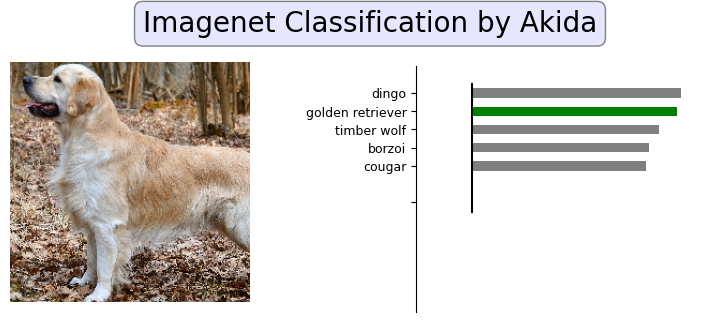

In [12]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing


# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]
    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0
    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(preprocessing.index_to_label(top5[ii]).split(',')[0])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(
            preprocessing.index_to_label(true_label).split(',')[0])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, yvals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Get a random image
rng = np.random.default_rng()
img = rng.integers(0, num_images)

# Predict image class
outputs_akida = model_akida.predict(np.expand_dims(x_test[img], axis=0)).squeeze()

# Get top 5 prediction labels and associated names
true_label = labels_test[img]
top5, yvals, class_name = get_top5(outputs_akida, true_label)

# Draw Plots
imgobj.set_data(x_test[img])
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()

## 4. Hardware mapping and performance



### 4.1. Map on hardware

List available Akida devices and check that an NSoC V2, Akida 1.0 production chip is available.

If a device is installed but not detected, reinstalling the driver might help, see the [driver
setup helper](https://github.com/Brainchip-Inc/akida_dw_edma/blob/master/README.md)_.

set_akida_version(AkidaVersion.v1)
device=akida.AKD1000()
pritn( device.version )

set_akida_version(AkidaVersion.v1)
device = akida.AKD1500()
pritn( device.version )

In [20]:
#devices = akida.devices()
#print(f'Available devices: {[dev.desc for dev in devices]}')
#assert len(devices), "No device found, this example needs an Akida NSoC_v2 device."
#device = devices[0]
#assert device.version == akida.NSoC_v2, "Wrong device found, this example needs an Akida NSoC_v2."

Map the model on the device



In [21]:
model_akida.map(device)

# Check model mapping: NP allocation and binary size
model_akida.summary()

NameError: name 'device' is not defined

### 4.2. Performance measurement

Power measurement must be enabled on the device' soc (disabled by default).
After sending data for inference, performance measurements are available in
the [model statistics](../../api_reference/akida_apis.html#akida.Model.statistics)_.



In [22]:
# Enable power measurement
device.soc.power_measurement_enabled = True

# Send data for inference
_ = model_akida.forward(x_test)

# Display floor current
floor_power = device.soc.power_meter.floor
print(f'Floor power: {floor_power:.2f} mW')

# Retrieve statistics
print(model_akida.statistics)

NameError: name 'device' is not defined